In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load data
# Replace with your data paths
news_data = pd.read_csv(r"C:\Users\marat\OneDrive\Desktop\2nd year\NLP-driven stock movement prediction\Reliance_News.csv")  # Assumes news_data has 'sentiment_score' and 'date'
stock_data = pd.read_csv(r"C:\Users\marat\OneDrive\Desktop\2nd year\NLP-driven stock movement prediction\reliance_stock_data.csv")  # Assumes stock_data has 'date', 'close', and 'movement'

# Preprocess stock data
# Create the Movement column
stock_data["Movement"] = (stock_data["Close"].diff() > 0).astype(int)


stock_data.head()

,Date,Close,Movement
0,2017-01-03,249.018509,0
1,2017-01-04,243.932541,0
2,2017-01-05,246.275513,1
3,2017-01-06,245.715485,0
4,2017-01-09,246.344086,1


In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import nltk

# Download VADER lexicon if not already downloaded
#nltk.download('vader_lexicon')

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores
news_data["Sentiment_Score"] = news_data["News"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Display the dataframe with sentiment scores
news_data.head()


,Date,News,sentiment,Sentiment_Score
0,2017-01-03,Get ready for some fund manager churning. Meen...,0.0,0.9774
1,2017-01-03,The Financial ExpressBharti Airtel chairman Su...,0.0,0.9134
2,2017-01-04,The Financial ExpressReliance Jio has announce...,1.0,0.9930
3,2017-01-06,MUMBAI: Reliance Retail is launching stores wh...,1.0,0.9477
4,2017-01-06,New Delhi: The volume of wireless broadband da...,0.0,0.9564


In [4]:
# Merge news and stock data
merged_data = pd.merge(news_data, stock_data, on='Date')
merged_data = merged_data.sort_values('Date')

# Feature selection
features = ['Sentiment_Score', 'Close']
X = merged_data[features]
y = merged_data['Movement']

print(merged_data['Movement'].value_counts())


Movement
1    805
0    556
Name: count, dtype: int64


In [5]:

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for LSTM
sequence_length = 10  # Use 10 days of data to predict movement
X_sequences = []
y_sequences = []

for i in range(sequence_length, len(X_scaled)):
    X_sequences.append(X_scaled[i-sequence_length:i])
    y_sequences.append(y.values[i])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
# Count of 1's
count_1 = np.count_nonzero(y_test == 1)

count_0 = np.count_nonzero(y_test == 0)

print(count_1)
print(count_0)
print(X_test)

160
111
[[[0.91991982 0.1991935 ]
  [0.99969932 0.1991935 ]
  [0.9870208  0.1991935 ]
  ...
  [0.99594087 0.21044918]
  [0.96887998 0.21044918]
  [0.99834628 0.2031906 ]]

 [[0.99809572 0.18038499]
  [0.99809572 0.18038499]
  [0.99218241 0.18055667]
  ...
  [0.99879729 0.19679033]
  [0.9771987  0.19679033]
  [0.97499374 0.21143004]]

 [[0.9929341  0.19382314]
  [0.99749436 0.19382314]
  [0.99699323 0.19382314]
  ...
  [0.89225758 0.19382314]
  [0.99789526 0.19382314]
  [0.99834628 0.19382314]]

 ...

 [[0.9905788  0.4079261 ]
  [0.99508895 0.40618504]
  [0.99894763 0.3933354 ]
  ...
  [0.99964921 0.40270293]
  [0.99759459 0.4028991 ]
  [0.99794538 0.41763692]]

 [[0.97113505 0.05413266]
  [0.99493861 0.05413266]
  [0.99428715 0.05413266]
  ...
  [0.98150839 0.05915969]
  [0.98892508 0.07053798]
  [0.98997745 0.0667493 ]]

 [[0.15269356 0.3930657 ]
  [0.93430218 0.40025065]
  [0.05362065 0.41888755]
  ...
  [0.99604109 0.43543996]
  [0.98672012 0.44517528]
  [0.96301679 0.44517528]]]


In [6]:
# Build the LSTM model
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


class_weight = {0: 1.5, 1: 1}  # Adjust the weight for class 0 to be higher
history =model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weight)


C:\python123\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4917 - loss: 0.8490 - val_accuracy: 0.5904 - val_loss: 0.6895
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5185 - loss: 0.8371 - val_accuracy: 0.5904 - val_loss: 0.6891
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5705 - loss: 0.8238 - val_accuracy: 0.5904 - val_loss: 0.6914
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5224 - loss: 0.8348 - val_accuracy: 0.4428 - val_loss: 0.6959
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5391 - loss: 0.8302 - val_accuracy: 0.5978 - val_loss: 0.6891
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5667 - loss: 0.8221 - val_accuracy: 0.6015 - val_loss: 0.6850
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5768 - loss: 0.8216 - val_accuracy: 0.4797 - val_loss: 0.6936
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5353 - loss: 0.8315 - val_accuracy: 0.6199 - v

In [7]:
# Evaluate the model
eval_loss, eval_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {eval_loss}, Test Accuracy: {eval_accuracy}")



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5590 - loss: 0.6819 
Test Loss: 0.6718324422836304, Test Accuracy: 0.5793358087539673


In [8]:
# Save the model
model.save('stock_movement_lstm_model.h5')



In [9]:
# Predict
y_pred = (model.predict(X_test) > 0.5).astype(int)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step 


In [10]:
count_1 = np.count_nonzero(y_pred == 1)

count_0 = np.count_nonzero(y_pred == 0)

print(count_1)
print(count_0)

198
73


In [11]:
# Predict

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

conf_matrix=confusion_matrix(y_test, y_pred)
# Evaluation metrics
print("Confusion Matrix:")

print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

Confusion Matrix:
[[ 35  76]
 [ 38 122]]
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.32      0.38       111
           1       0.62      0.76      0.68       160

    accuracy                           0.58       271
   macro avg       0.55      0.54      0.53       271
weighted avg       0.56      0.58      0.56       271

Accuracy: 0.5793357933579336
Precision: 0.6161616161616161
Recall: 0.7625
F1 Score: 0.6815642458100558


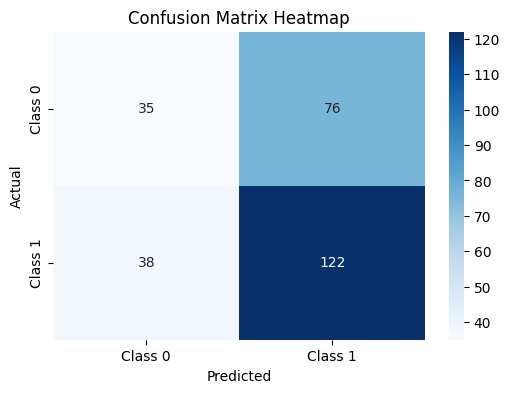

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.savefig(r'C:\Users\marat\OneDrive\Desktop\2nd year\project\confmat.png', format='png', dpi=300)
plt.show()


In [15]:
# Predict next 20 days
last_sequence = X_scaled[-sequence_length:]
future_predictions = []

for _ in range(10):
    # Reshape last_sequence for prediction
    last_sequence_reshaped = last_sequence.reshape(1, sequence_length, -1)
    next_prediction = model.predict(last_sequence_reshaped)
    future_predictions.append(int(next_prediction > 0.5))

    # Update the sequence with the predicted value (use the last known close price and sentiment score)
    new_row = np.append(last_sequence[-1, :-1], next_prediction)  # Replace with better handling if additional features are needed
    last_sequence = np.append(last_sequence[1:], new_row.reshape(1, -1), axis=0)

print("Next 20 Days Predictions:", future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

C:\Users\marat\AppData\Local\Temp\ipykernel_17864\2603602501.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  future_predictions.append(int(next_prediction > 0.5))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Next 20 Days Predictions: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
